In [2]:
import os
import email
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from os import path
import re
import csv
import tensorflow as tf
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu
from sklearn.utils import shuffle
import nltk
import random
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
from multiprocessing import  Pool
from nltk.corpus import reuters


In [5]:
df = pd.read_csv("emails.csv")
df = df.sample(frac=0.35, random_state=42)
df.reset_index(inplace = True, drop = True)

In [6]:
df.head()

,file,message
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...


In [7]:
df.shape

(181090, 2)

In [8]:
df['message'][0]

'Message-ID: <21013688.1075844564560.JavaMail.evans@thyme>\nDate: Tue, 29 Aug 2000 01:26:00 -0700 (PDT)\nFrom: sara.shackleton@enron.com\nTo: william.bradford@enron.com\nSubject: Re: Credit Derivatives\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Sara Shackleton\nX-To: William S Bradford\nX-cc: \nX-bcc: \nX-Folder: \\Sara_Shackleton_Dec2000_June2001_1\\Notes Folders\\Sent\nX-Origin: SHACKLETON-S\nX-FileName: sshackle.nsf\n\nBill:  Thanks for the info.   I also spoke with Jeff about how \nEnronCredit.com Ltd. was going to work since Dennis O\'Connell (London lawyer) \nis responsible for that group.  Maybe you will be able to clarify which of \nJeff\'s "positions" will be hedges and which will be backed to EnronCredit.  \nMaybe Rod will be handling most of Jeff\'s credit.  I\'d appreciate an update.  \nSara\n\n\n\n\tWilliam S Bradford\n\t08/29/2000 07:24 AM\n\t\t\n\t\t To: Sara Shackleton/HOU/ECT@ECT\n\t\t cc: Mark Taylor/HOU/EC

In [9]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

df['content'] = body(df['message'])

In [10]:
df.head()


,file,message,content
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,Bill: Thanks for the info. I also spoke wit...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,"Aimee,\nPlease check meter #1591 Lamay gas lif..."
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,GCCA Crawfish and rip-off raffle & over-priced...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,"<<Keoni.zip>> Chris, per your request here ar..."
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,I'm trying to change the Receipt Meter on deal...


In [11]:
df.content = df.content.str.replace("\n","")
df.content = df.content.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df.content = df.content.str.lower()
df.content = df.content.str.strip()

In [12]:
df.head()

,file,message,content
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,bill thanks for the info i also spoke with jef...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,aimee please check meter 1591 lamay gas lift i...
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,gcca crawfish and rip off raffle over priced p...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,keoni zip chris per your request here are the ...
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,i m trying to change the receipt meter on deal...


In [13]:
df['body_list'] = df.content.apply(lambda x: x.split())

In [14]:
df.head()

,file,message,content,body_list
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,bill thanks for the info i also spoke with jef...,"[bill, thanks, for, the, info, i, also, spoke,..."
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,aimee please check meter 1591 lamay gas lift i...,"[aimee, please, check, meter, 1591, lamay, gas..."
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,gcca crawfish and rip off raffle over priced p...,"[gcca, crawfish, and, rip, off, raffle, over, ..."
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,keoni zip chris per your request here are the ...,"[keoni, zip, chris, per, your, request, here, ..."
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,i m trying to change the receipt meter on deal...,"[i, m, trying, to, change, the, receipt, meter..."


Text(0, 0.5, 'Frequency')

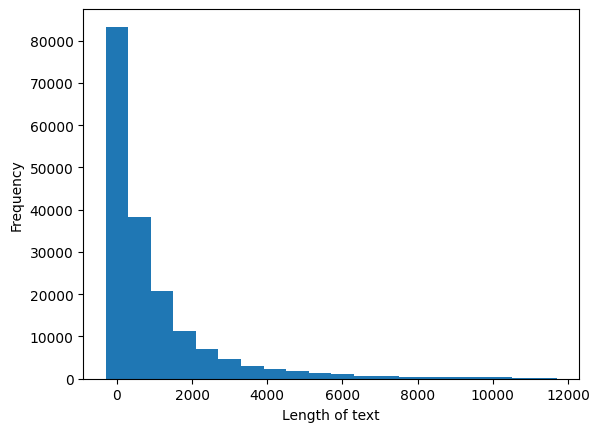

In [15]:
  # EDA for text length
x = list(df['content'].apply(lambda x:len(x)))
plt.hist(x,range=[1,12000],bins = 20,align ='left')
plt.rcParams["figure.figsize"] = (10,4)
plt.xlabel("Length of text")
plt.ylabel("Frequency")

In [16]:
if __name__ == "__main__":
  for i in range(0,110,10):
    print("{}th- percentile of len(text) is {}".format(i,np.percentile(x, i)))
    print("="*40)
  x =None
  del(x)
  gc.collect()

0th- percentile of len(text) is 0.0
10th- percentile of len(text) is 100.0
20th- percentile of len(text) is 199.0
30th- percentile of len(text) is 325.0
40th- percentile of len(text) is 483.0
50th- percentile of len(text) is 687.0
60th- percentile of len(text) is 956.0
70th- percentile of len(text) is 1314.0
80th- percentile of len(text) is 1909.0
90th- percentile of len(text) is 3282.0
100th- percentile of len(text) is 1594315.0


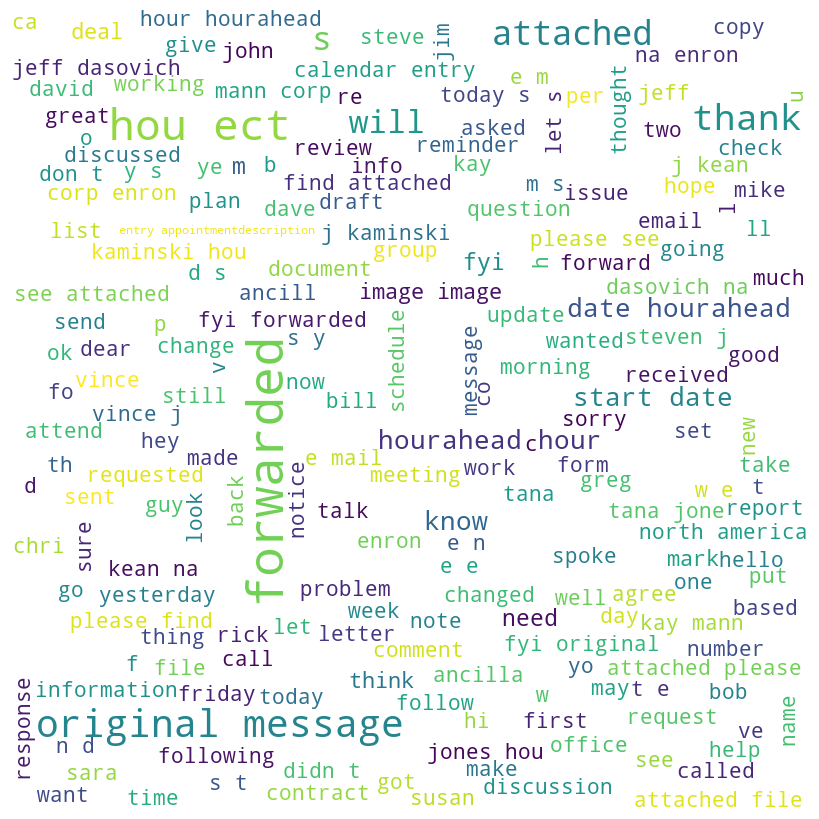

In [17]:
if __name__ == "__main__":
  # Word cloud for content , X-TO, X-From
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS ,
                max_font_size = 50,
                min_font_size = 10).generate(df['content'].to_string())
  # plot the WordCloud image
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()